In [2]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
#Load the training data
col_names = ['A', 'B', 'deltaI', 'deltaR', 'E', 'k']
peak_names = ['peak1', 'peak2', 'peak3', 'peak4', 'peak5']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4', 'loc5']
width_names = ['width1', 'width2', 'width3','width4', 'width5']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4', 'prom5']
col_names = col_names + peak_names + locs_names + width_names + prom_names

data = pd.read_csv('LineCutTrainingData052118_fixedfit.csv', header = None, names = col_names)

# Loading Experimental Data 
data_exp = pd.read_csv('LineCutExpData180530.csv', header = None, names = col_names) 

#The peak information columns have zeros when there weren't 5 peaks

data.head()

,A,B,deltaI,deltaR,E,k,peak1,peak2,peak3,peak4,...,width1,width2,width3,width4,width5,prom1,prom2,prom3,prom4,prom5
0,-0.38805,-0.22596,0.81472,-0.14798,-0.4,0.06469,0.99666,0.31311,0.19045,0.17845,...,1.4630,46.800,50.281,32.218,0.000,1.27010,0.53509,0.37420,0.15110,0.00000
1,-0.33357,-0.16418,0.81472,-0.14798,-0.3,0.12292,0.82062,0.25860,0.15841,0.13729,...,1.5461,24.827,26.035,27.184,26.446,1.28980,0.45609,0.30073,0.26413,0.20762
2,-0.30657,-0.15064,0.81472,-0.14798,-0.2,0.16228,0.71396,0.23300,0.14533,0.12049,...,1.4174,18.767,19.882,20.103,20.188,1.12150,0.41003,0.27792,0.22411,0.18490
3,-0.28211,-0.14453,0.81472,-0.14798,-0.1,0.19463,0.62981,0.21673,0.13800,0.10512,...,1.3712,15.619,16.632,16.654,17.221,0.99603,0.37978,0.26048,0.20270,0.18805
4,-0.26310,-0.13547,0.81472,-0.14798,0.0,0.22312,0.55621,0.20383,0.13048,0.10268,...,1.3342,13.635,14.398,14.818,14.560,0.87763,0.35828,0.24145,0.19974,0.16361


## Creating the various test, train, data sets

In [32]:
target = data[['deltaI', 'deltaR']]

train1 = data[['A', 'B', 'E', 'k']]
train2 = data[['A', 'B', 'E']]

##Just the entries with E = -0.4
#train_E_04 = train1[train1['E']==-0.4]
#target_E_04 = target[train1['E']==-0.4]
#train_E_04_a = train_E_04[['A', 'B']] 

# Making a copy of the data frame
df1 = data

columns1 = df1.columns
X1 = df1.drop(columns1[2:4], axis = 1) # everything except target
X2 = X1.drop(columns1[6:], axis = 1) # no additional peak info
X3 = X2.drop(columns1[4:6], axis = 1) # no E, k

Y1 = df1[['deltaR']]
Y2 = df1[['deltaI']]
Y3 = pd.DataFrame.join(Y1,Y2)

# Making another copy of the data frame
df2 = df1

n1 = int(len(df1['deltaR'])/9)

# Initializing a new dataframe to use the average peaks, prominences and widths as features instead of each one
new_df = pd.DataFrame(np.zeros([n1,7]), columns = ['deltaI', 'deltaR', 'avgA', 'avgB', 'avgPeak', 'avgWidth', 'avgProm'])
for i in range(1,n1+1):
        
        temp_df = df2[9*(i-1):9*i]
        columns = temp_df.columns
        new_df['deltaI'][i-1] = temp_df['deltaI'].mean()
        new_df['deltaR'][i-1] = temp_df['deltaR'].mean()
        
        new_df['avgA'][i-1] = temp_df['A'].mean()
        new_df['avgB'][i-1] = temp_df['B'].mean()
        
        new_df['avgPeak'][i-1] = temp_df[columns[6:11]][temp_df[columns[6:11]]>0].mean().mean()
        
        new_df['avgWidth'][i-1] = temp_df[columns[11:16]][temp_df[columns[11:16]]>0].mean().mean()
        
        new_df['avgProm'][i-1] = temp_df[columns[16:21]][temp_df[columns[16:21]]>0].mean().mean()
        
        
# new_df.head()
new_columns = new_df.columns
X_new_df = new_df.drop(new_columns[0:2], axis=1)
Y_new_df = new_df.drop(new_columns[2:], axis = 1)

## Creating experimental data x 
X1_exp = data_exp.drop(columns1[2:4], axis = 1) # everything except target
X2_exp = X1_exp.drop(columns1[6:], axis = 1) # no additional peak info
X3_exp = X2_exp.drop(columns1[4:6], axis = 1) # no E, k

#### Splitting each dataset in the previous cell into train and test

In [6]:
#Random state
rs = 42
#Test size
ts1 = 0.3

X_a_train, X_a_test, Y_a_train, Y_a_test = train_test_split(train1, target, test_size = ts1, random_state = rs)

X_b_train, X_b_test, Y_b_train, Y_b_test = train_test_split(train2, target, test_size = ts1, random_state = rs)

#Splitting X1, Y1 into train and test
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs)

#Splitting X2, Y2 into train and test
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs)

#Splitting X3, Y3 into train and test
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size = ts1, random_state = rs)

#Splitting X_new_df, Y_new_df into train and test
X_new_train, X_new_test, Y_new_train, Y_new_test = train_test_split(X_new_df, Y_new_df, test_size = ts1, random_state = rs)



## Making models

### Using Decision Trees in scikit-learn to predict deltaI and deltaR simultaneously

In [8]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
import pylab

#Initialize the models
regr_1 = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3 = DecisionTreeRegressor(max_depth=40, min_samples_leaf=5)

#Fit the models
regr_1.fit(X1_train, Y3_train)
regr_2.fit(X1_train, Y3_train)
regr_3.fit(X1_train, Y3_train)

In [101]:
# Make Predictions 
y_exp_1 = regr_1.predict(X1_exp)
y_exp_2 = regr_2.predict(X1_exp)

# Print Predictions 
print('Predicted Values of delta (Energies 2:9) - using X1 - A, B, E, k, peak information \n Max Depth = 10 \n', y_exp_1,'\n\n Max Depth= 20 \n', y_exp_2)
deltaI_avg_X1_depth10 = np.mean(y_exp_1[0:9,0])
deltaR_avg_X1_depth10 = np.mean(y_exp_1[0:9,1])

deltaI_avg_X1_depth20 = np.mean(y_exp_2[0:9,0])
deltaR_avg_X1_depth20 = np.mean(y_exp_2[0:9,1])
print('\n deltaI_average_depth10 ', round(deltaI_avg_X1_depth10, 6), ' deltaR_average_depth10 ', round(deltaR_avg_X1_depth10,6))
print('\n deltaI_average_depth20 ', round(deltaI_avg_X1_depth20, 6), ' deltaR_average_depth20 ', round(deltaR_avg_X1_depth20,6))

Predicted Values of delta (Energies 2:9) - using X1 - A, B, E, k, peak information 
 Max Depth = 10 
 [[-0.028424    0.01718783]
 [-0.18189862  0.03692186]
 [-0.25807741  0.10531585]
 [-0.01517157  0.19562571]
 [-0.26480429  0.37772286]
 [-0.0432106   0.47657286]
 [-0.05336     0.63909   ]
 [-0.07661733  0.70026333]
 [-0.01318271  0.16315714]] 

 Max Depth= 20 
 [[-0.028424    0.01718783]
 [-0.18884375  0.05937475]
 [-0.22838     0.099917  ]
 [-0.24129     0.298966  ]
 [-0.26480429  0.37772286]
 [-0.0432106   0.47657286]
 [-0.0202127   0.533558  ]
 [-0.0202127   0.533558  ]
 [-0.04671033  0.08848689]]

 deltaI_average_depth10  -0.103861  deltaR_average_depth10  0.301317

 deltaI_average_depth20  -0.120232  deltaR_average_depth20  0.276149


In [29]:
#Decision tree with different X features - no peak info (X2)
#Initialize the models
regr_1b = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2b = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3b = DecisionTreeRegressor(max_depth=30, min_samples_leaf=5)

#Fit the models
regr_1b.fit(X2_train, Y3_train)
regr_2b.fit(X2_train, Y3_train)
regr_3b.fit(X2_train, Y3_train)

In [104]:
# Make Predictions
y_exp_1b = regr_1b.predict(X2_exp)
y_exp_2b = regr_2b.predict(X2_exp)

# Print Predictions 
print('Predicted Values of delta (Energies 2:9) - using X2 - A, B, E, k \n Max Depth = 10 \n', y_exp_1b,'\n\n Max Depth= 20 \n', y_exp_2b)
deltaI_avg_X2_depth10 = np.mean(y_exp_1b[0:9,0])
deltaR_avg_X2_depth10 = np.mean(y_exp_1b[0:9,1])

deltaI_avg_X2_depth20 = np.mean(y_exp_2b[0:9,0])
deltaR_avg_X2_depth20 = np.mean(y_exp_2b[0:9,1])
print('\n deltaI_average_depth10 ', round(deltaI_avg_X2_depth10, 6), ' deltaR_average_depth10 ', round(deltaR_avg_X2_depth10,6))
print('\n deltaI_average_depth20 ', round(deltaI_avg_X2_depth20, 6), ' deltaR_average_depth20 ', round(deltaR_avg_X2_depth20,6))

Predicted Values of delta (Energies 2:9) - using X2 - A, B, E, k 
 Max Depth = 10 
 [[-0.07899138  0.02429213]
 [-0.1097486   0.01420028]
 [-0.15483778  0.11099567]
 [-0.144596    0.09555   ]
 [-0.18103833  0.05445467]
 [-0.18103833  0.05445467]
 [-0.18215077  0.02232088]
 [-0.142218    0.05638687]
 [-0.1263025   0.00915116]] 

 Max Depth= 20 
 [[-0.07899138  0.02429213]
 [-0.1097486   0.01420028]
 [-0.15483778  0.11099567]
 [-0.144064    0.0963032 ]
 [-0.18103833  0.05445467]
 [-0.18103833  0.05445467]
 [-0.19193143  0.0247    ]
 [-0.14207111  0.04243767]
 [-0.1263025   0.00915116]]

 deltaI_average_depth10  -0.144547  deltaR_average_depth10  0.04909

 deltaI_average_depth20  -0.145558  deltaR_average_depth20  0.047888


In [31]:
#Decision tree with different X features - just A, phi (X3)
#Initialize the models
regr_1c = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2c = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3c = DecisionTreeRegressor(max_depth=30, min_samples_leaf=5)

#Fit the models
regr_1c.fit(X3_train, Y3_train)
regr_2c.fit(X3_train, Y3_train)
regr_3c.fit(X3_train, Y3_train)

In [105]:
# Make Predictions
y_exp_1c = regr_1c.predict(X3_exp)
y_exp_2c = regr_2c.predict(X3_exp)

# Print Predictions
print('Predicted Values of delta (Energies 2:9) - using X3 - A, B \n Max Depth = 10 \n', y_exp_1c,'\n\n Max Depth= 20 \n', y_exp_2c)
ddeltaI_avg_X3_depth10 = np.mean(y_exp_1c[0:9,0])
deltaR_avg_X3_depth10 = np.mean(y_exp_1c[0:9,1])

deltaI_avg_X3_depth20 = np.mean(y_exp_2c[0:9,0])
deltaR_avg_X3_depth20 = np.mean(y_exp_2c[0:9,1])
print('\n deltaI_average_depth10 ', round(deltaI_avg_X3_depth10, 6), ' deltaR_average_depth10 ', round(deltaR_avg_X3_depth10,6))
print('\n deltaI_average_depth20 ', round(deltaI_avg_X3_depth20, 6), ' deltaR_average_depth20 ', round(deltaR_avg_X3_depth20,6))

Predicted Values of delta (Energies 2:9) - using X3 - A, B 
 Max Depth = 10 
 [[-0.10667033  0.048408  ]
 [-0.23797778  0.10183044]
 [-0.22023625  0.1438225 ]
 [-0.144596    0.09555   ]
 [-0.10667033  0.048408  ]
 [-0.186382    0.0549038 ]
 [-0.13630167  0.0103486 ]
 [-0.13238418  0.03917955]
 [-0.1263025   0.00915116]] 

 Max Depth= 20 
 [[-0.10667033  0.048408  ]
 [-0.23797778  0.10183044]
 [-0.22023625  0.1438225 ]
 [-0.144064    0.0963032 ]
 [-0.10667033  0.048408  ]
 [-0.186382    0.0549038 ]
 [-0.13630167  0.0103486 ]
 [-0.143762    0.0444104 ]
 [-0.1263025   0.00915116]]

 deltaI_average_depth10  -0.166364  deltaR_average_depth10  0.061289

 deltaI_average_depth20  -0.156485  deltaR_average_depth20  0.061954


The Standard Deviation on X1, Delta I, depth 10 is 0.097
The Standard Deviation on X1, Delta I, depth 20 is 0.101
 
The Standard Deviation on X1, Delta R, depth 10 is 0.242
The Standard Deviation on X1, Delta R, depth 20 is 0.201
 
The Standard Deviation on X2, Delta I, depth 10 is 0.033
The Standard Deviation on X2, Delta I, depth 20 is 0.035
 
The Standard Deviation on X2, Delta R, depth 10 is 0.034
The Standard Deviation on X2, Delta R, depth 20 is 0.034
 
The Standard Deviation on X3, Delta I, depth 10 is 0.045
The Standard Deviation on X3, Delta I, depth 20 is 0.045
 
The Standard Deviation on X3, Delta R, depth 10 is 0.042
The Standard Deviation on X3, Delta R, depth 20 is 0.042
 


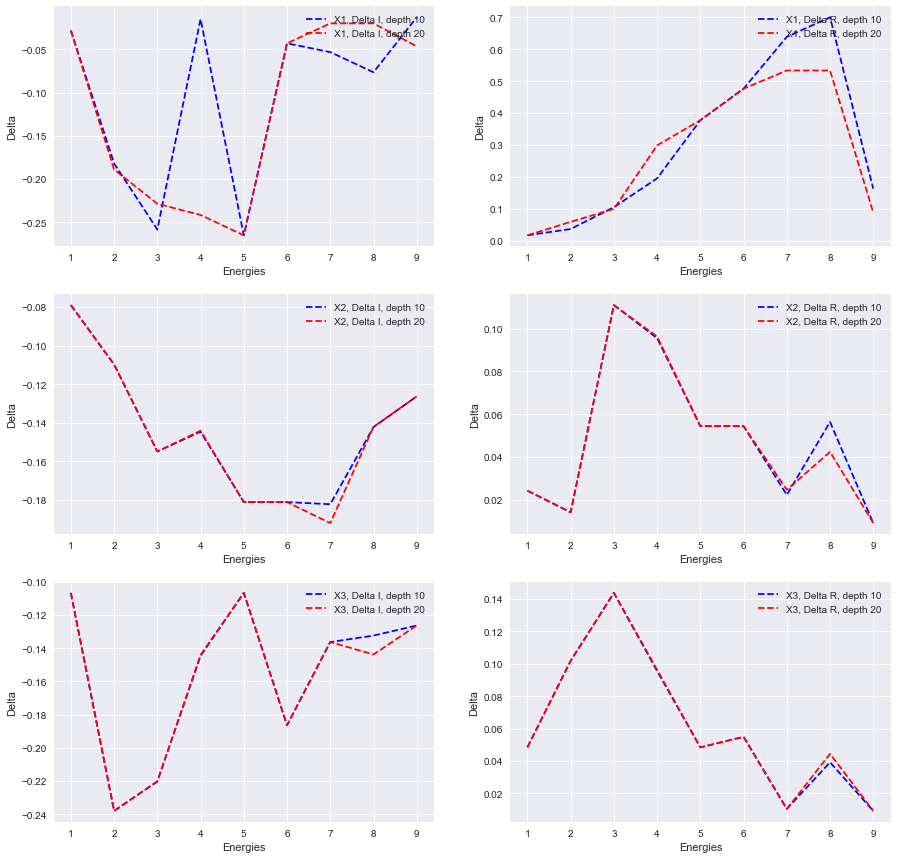

In [106]:
# Creating Vectors
xAxis = [1, 2, 3, 4, 5, 6, 7, 8, 9]
y_exp_1_I = y_exp_1[0:9,0]
y_exp_1_R = y_exp_1[0:9, 1]
y_exp_2_I = y_exp_2[0:9,0]
y_exp_2_R = y_exp_2[0:9, 1]

y_exp_1b_I = y_exp_1b[0:9,0]
y_exp_1b_R = y_exp_1b[0:9, 1]
y_exp_2b_I = y_exp_2b[0:9,0]
y_exp_2b_R = y_exp_2b[0:9, 1]

y_exp_1c_I = y_exp_1c[0:9,0]
y_exp_1c_R = y_exp_1c[0:9, 1]
y_exp_2c_I = y_exp_2c[0:9,0]
y_exp_2c_R = y_exp_2c[0:9, 1]

# Plotting Function 
def myplotting(xAxis, yAxis1, yAxis2, key_label_1, key_label_2):
    std1 = np.std(yAxis1)
    std2 = np.std(yAxis2)
    print('The Standard Deviation on', key_label_1, 'is', round(std1,3))
    print('The Standard Deviation on', key_label_2, 'is', round(std2,3))
    print(' ')
    ax.plot(xAxis, yAxis1, 'b--', label = key_label_1)
    ax.plot(xAxis, yAxis2, 'r--', label = key_label_2)
    pylab.xlabel('Energies')
    pylab.ylabel('Delta')
    pylab.legend(loc='upper right')
    

# Plotting
f,(ax) = plt.subplots(figsize=(15,15))
ax = pylab.subplot(321) 

myplotting(xAxis, y_exp_1_I, y_exp_2_I, 'X1, Delta I, depth 10', 'X1, Delta I, depth 20')
ax = pylab.subplot(322) 
myplotting(xAxis, y_exp_1_R, y_exp_2_R, 'X1, Delta R, depth 10', 'X1, Delta R, depth 20')
ax = pylab.subplot(323) 

myplotting(xAxis, y_exp_1b_I, y_exp_2b_I, 'X2, Delta I, depth 10', 'X2, Delta I, depth 20')
ax = pylab.subplot(324) 
myplotting(xAxis, y_exp_1b_R, y_exp_2b_R, 'X2, Delta R, depth 10', 'X2, Delta R, depth 20')
ax = pylab.subplot(325) 

myplotting(xAxis, y_exp_1c_I, y_exp_2c_I, 'X3, Delta I, depth 10', 'X3, Delta I, depth 20')
ax = pylab.subplot(326) 
myplotting(xAxis, y_exp_1c_R, y_exp_2c_R, 'X3, Delta R, depth 10', 'X3, Delta R, depth 20')




# Random Forest

One way to improve the effectiveness of decision trees and reduce the risk of overfitting, is to implement a random forest, where there are several decision trees and certain nodes within are randomly removed to avoid having one node affect the results too much. Could also use bagging to avoid overfitting. 


From the scikit-learn page for RandomForestRegressor:
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [82]:
from sklearn.ensemble import RandomForestRegressor
rs = 42

# Training 
regr_rf = RandomForestRegressor(max_depth = 15,  random_state=rs, n_estimators = 15);
regr_rf.fit(X1_train, Y3_train);
pd.Series(regr_rf.feature_importances_, index= X1_train.columns);


In [77]:
# Predicting
predict_exp = pd.DataFrame(regr_rf.predict(X1_exp), columns = ['deltaI', 'deltaR'])
print('Energies 2:8 using X1 - A, B, E, k, peak information ')
print(predict_exp)
deltaI_avg_rf = np.mean(predict_exp.loc[1:8,'deltaI'])
deltaR_avg_rf = np.mean(predict_exp.loc[1:8,'deltaR'])
print('deltaI_average ', round(deltaI_avg_rf, 3), ' deltaR_average ', round(deltaR_avg_rf,6))

Energies 2:8 using X1 - A, B, E, k, peak information 
     deltaI    deltaR
0 -0.048114  0.022677
1 -0.114146  0.044820
2 -0.193264  0.115342
3 -0.152856  0.141460
4 -0.206754  0.146789
5 -0.204278  0.163496
6 -0.137940  0.210202
7 -0.154029  0.204182
8 -0.028424  0.164063
deltaI_average  -0.149  deltaR_average  0.148794


In [83]:
# Training
regr_rf2 = RandomForestRegressor(max_depth = 15,  random_state=rs, n_estimators = 15);
regr_rf2.fit(X2_train, Y3_train);
pd.Series(regr_rf2.feature_importances_, index= X2_train.columns);


In [84]:
# Predicting 
predict2_exp = pd.DataFrame(regr_rf2.predict(X2_exp), columns = ['deltaI', 'deltaR'])
print('Energies 2:8 using X2 - A, B, E, k ')
print(predict2_exp)
deltaI_avg_rf2 = np.mean(predict2_exp.loc[1:8,'deltaI'])
deltaR_avg_rf2 = np.mean(predict2_exp.loc[1:8,'deltaR'])
print('deltaI_average ', round(deltaI_avg_rf2, 3), ' deltaR_average ', round(deltaR_avg_rf2,6))

Energies 2:8 using X2 - A, B, E, k 
     deltaI    deltaR
0 -0.077869  0.032119
1 -0.131281  0.046959
2 -0.143596  0.086664
3 -0.143874  0.093312
4 -0.151802  0.053588
5 -0.169978  0.050517
6 -0.155785  0.014518
7 -0.149869  0.047618
8 -0.136626  0.006934
deltaI_average  -0.148  deltaR_average  0.050014


In [85]:
# Training 
regr_rf3 = RandomForestRegressor(max_depth = 15,  random_state=rs, n_estimators= 15);
regr_rf3.fit(X3_train, Y3_train);
pd.Series(regr_rf3.feature_importances_, index= X3_train.columns);

In [86]:
# Predicting 
predict3_exp = pd.DataFrame(regr_rf3.predict(X3_exp), columns = ['deltaI', 'deltaR'])
print('Energies 2:8 using X3 - A, B ')
print(predict3_exp)
deltaI_avg_rf3 = np.mean(predict3_exp.loc[1:8,'deltaI'])
deltaR_avg_rf3 = np.mean(predict3_exp.loc[1:8,'deltaR'])
print('deltaI_average ', round(deltaI_avg_rf3, 3), ' deltaR_average ', round(deltaR_avg_rf3,6))

Energies 2:8 using X3 - A, B 
     deltaI    deltaR
0 -0.126356  0.058671
1 -0.251999  0.097344
2 -0.248743  0.144872
3 -0.144704  0.094488
4 -0.140314  0.051984
5 -0.160945  0.045074
6 -0.143060  0.017020
7 -0.150947  0.047531
8 -0.131186  0.005234
deltaI_average  -0.171  deltaR_average  0.062943


deltaI_average  -0.149  deltaR_average  0.148794
The Standard Deviation on X1, Delta I is 0.061
The Standard Deviation on X1, Delta R is 0.061
 
deltaI_average  -0.148  deltaR_average  0.050014
The Standard Deviation on X2, Delta I is 0.024
The Standard Deviation on X2, Delta R is 0.027
 
deltaI_average  -0.171  deltaR_average  0.062943
The Standard Deviation on X3, Delta I is 0.046
The Standard Deviation on X3, Delta R is 0.041
 


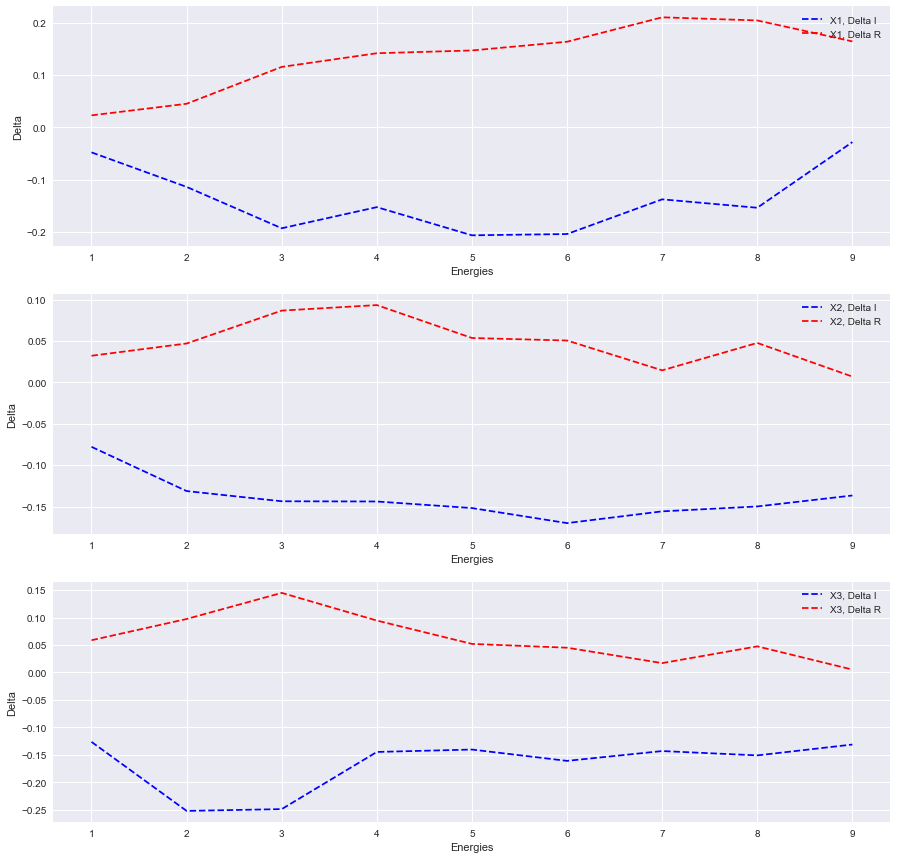

In [97]:
# Creating Vectors
xAxis = [1, 2, 3, 4, 5, 6, 7, 8, 9]

predict_I = predict_exp.loc[0:9,'deltaI']
predict_R = predict_exp.loc[0:9,'deltaR']

predict2_I = predict2_exp.loc[0:9,'deltaI']
predict2_R = predict2_exp.loc[0:9,'deltaR']

predict3_I = predict3_exp.loc[0:9,'deltaI']
predict3_R = predict3_exp.loc[0:9,'deltaR']


# Plotting
f,(ax) = plt.subplots(figsize=(15,15))
ax = pylab.subplot(311) 
print('deltaI_average ', round(deltaI_avg_rf, 3), ' deltaR_average ', round(deltaR_avg_rf,6))
myplotting(xAxis, predict_I, predict_R, 'X1, Delta I', 'X1, Delta R')
ax = pylab.subplot(312) 
print('deltaI_average ', round(deltaI_avg_rf2, 3), ' deltaR_average ', round(deltaR_avg_rf2,6))
myplotting(xAxis, predict2_I, predict2_R, 'X2, Delta I', 'X2, Delta R')
ax = pylab.subplot(313) 
print('deltaI_average ', round(deltaI_avg_rf3, 3), ' deltaR_average ', round(deltaR_avg_rf3,6))
myplotting(xAxis, predict3_I, predict3_R, 'X3, Delta I', 'X3, Delta R')

